In [1]:
import time

## Data wrangling
import pandas as pd
import numpy as np

## Visualization
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import warnings
warnings.filterwarnings('ignore')

## Machine learning
from sklearn.preprocessing import normalize, Normalizer
from sklearn.model_selection import ParameterGrid
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import precision_score, f1_score, recall_score, roc_auc_score, roc_curve, auc

## Spatial data wrangling
import geopandas as gpd
from shapely.geometry import Point, Polygon

import multiprocessing
print('Number of CPUS: ' +str(multiprocessing.cpu_count()))

import datetime as dt     
date = dt.datetime.today().strftime("%Y/%m/%d")
today = pd.to_datetime(date)
print (date)

Number of CPUS: 2
2018/07/11


## Set Model Parameters

In [2]:
outcome = 'activity'

offset = 3

year = 2017
month = 10

random_state = 5881

## DataFrame to hold model performance data for each set of hyperparameters
all_results = pd.DataFrame()
all_importances = pd.DataFrame()

In [3]:
models_to_run = ['RF']

clfs = {
    'RF': RandomForestClassifier(n_estimators=50, n_jobs=-1, random_state = random_state),
    'ET': ExtraTreesClassifier(n_estimators=10, n_jobs=-1, random_state = random_state),
    'LR': LogisticRegression(penalty='l1', C=1e5, random_state = random_state),
    'SVM': SVC(kernel='linear', probability=True, random_state = random_state),
    'GB': GradientBoostingClassifier(learning_rate=0.05, subsample=0.5, max_depth=6, n_estimators=10, random_state = random_state)
    }
grid = {
    'RF':{'n_estimators': [250], 'max_depth': [10], 
          'max_features': [0.25],'min_samples_split': [2],'criterion':['gini']},
        'GB': {'n_estimators': [250], 'learning_rate' : [0.1],
           'subsample' : [0.5], 'max_depth': [10]}
}

## Defining Functions

In [4]:
def data_prep(date_offset=1):
    
    blks = pd.read_csv('data/census_blocks.csv.gz')
    blks['GEOID'] = blks['GEOID'].astype(str)
    blks = blks.set_index('GEOID')

    geo_rats = pd.read_csv('data/rats_to_blocks.csv.gz')
    geo_rats['GEOID'] = geo_rats['GEOID'].astype(str)

    geo_bbl = pd.read_csv('data/bbls_to_blocks.csv.gz')
    geo_bbl['GEOID'] = geo_bbl['GEOID'].astype(str)

    geo_permits = pd.read_csv('data/permits_to_blocks.csv.gz')
    geo_permits['GEOID'] = geo_permits['GEOID'].astype(str)

    geo_mar = pd.read_csv('data/address_units_to_blocks.csv.gz')
    geo_mar['GEOID'] = geo_mar['GEOID'].astype(str)
    geo_mar = geo_mar.set_index('GEOID')

    geo_cama = pd.read_csv('data/cama_to_blocks.csv.gz')
    geo_cama['GEOID'] = geo_cama['GEOID'].astype(str)
    geo_cama = geo_cama.set_index('GEOID')

    dcgis = pd.read_csv('data/env_features.csv.gz')
    dcgis['GEOID'] = dcgis['GEOID'].astype(str)
    dcgis = dcgis.set_index('GEOID')

    years = np.sort(geo_rats.year.unique())
    years = years[~np.isnan(years)]
    
    data = pd.DataFrame()
    for year in years:

        year = int(year)
        this_year = geo_rats[geo_rats.year==year]
        months = np.sort(this_year.month.astype(int).unique())

        for month in months:
            month = int(month)
            date = pd.datetime(year, month, 1)

            ## Get outcome for month
            mrats = geo_rats[(pd.to_datetime(geo_rats.SERVICEORDERDATE) >= date) 
                             & (pd.to_datetime(geo_rats.SERVICEORDERDATE) < date + pd.DateOffset(months=date_offset))]
            mrats_3 = geo_rats[(pd.to_datetime(geo_rats.SERVICEORDERDATE) <= date) 
                             & (pd.to_datetime(geo_rats.SERVICEORDERDATE) > date - pd.DateOffset(months=3))]
            mrats = mrats.fillna(0)
            mrats_3 = mrats_3.fillna(0)
            rats_by_block = pd.DataFrame(mrats.groupby(['GEOID'])[['calls', 'activity']].sum())
            rats_by_block['calls'] = 1*(rats_by_block['calls'] > 0)
            rats_by_block['activity'] = 1*(rats_by_block['activity'] > 0)

            ## Rat call in last 3 months
            rats_past_3m = pd.DataFrame(mrats_3.groupby(['GEOID'])[['calls']].sum())
            rats_past_3m['call_past_3m'] = 1*(rats_past_3m['calls'] > 0)
            rats_past_3m = rats_past_3m.drop(['calls'], axis=1)
            
            ## Merge to full set Census blocks and fill NA's with zeroes 
            mdata = blks.merge(rats_by_block, how='left', left_index=True, right_index=True)
            mdata = mdata.merge(rats_past_3m, how='left', left_index=True, right_index=True)

            ## Get month and year vars
            mdata['year'] = year
            mdata['month']= month
            mmonths = pd.get_dummies(mdata['month'], prefix='month')
            myears = pd.get_dummies(mdata['year'], prefix='year')
            mdata = mdata.merge(mmonths, how='left', left_index=True, right_index=True)
            mdata = mdata.merge(myears, how='left', left_index=True, right_index=True)
            mdata['yearmonth'] = mdata['year'] + (mdata['month']*1.0/12)
            mdata['yearmonth'].describe().T
            mdata = mdata.fillna(0)

            ## Adding BBLs that started before the beginning of this month but ended after
            businesses = ['bbl_food',  'bbl_hotel', 'bbl_pool', 'bbl_restaurant', 'bbl_storage', 
                        'bbl_multifamily_rental', 'bbl_single_family_rental', 'bbl_two_family_rental', 'bbl_waste']
            mbbls = geo_bbl[(pd.to_datetime(geo_bbl.license_start_date) <= date) & (pd.to_datetime(geo_bbl.license_exp_date) > date)]
            bbls_by_block = pd.DataFrame(mbbls.groupby('GEOID')[businesses].sum())
            mdata = mdata.merge(bbls_by_block, how='left', left_index=True, right_index=True)

            ## Adding permits issued before the date but not more than 12 months before
            permits = ['dcrapermit_new_building', 'dcrapermit_demolition', 'dcrapermit_raze', 'dcrapermit_addition', 
                   'dcrapermit_retain_wall', 'dcrapermit_excavation', 'dcrapermit_pool', 'dcrapermit_garage']
            mpermits = geo_permits[(pd.to_datetime(geo_permits.issue_date) <= date) & ((pd.to_datetime(geo_permits.issue_date) + pd.DateOffset(months=12)) > date)]
            permits_by_block = pd.DataFrame(mpermits.groupby('GEOID')[permits].sum())
            mdata = mdata.merge(permits_by_block, how='left', left_index=True, right_index=True)

            ## Add DCGIS data (prepped in separate script)
            mdata = mdata.merge(geo_mar, how='left', left_index=True, right_index=True)
            mdata = mdata.fillna(0)

            ## Add DCGIS data (prepped in separate script)
            mdata = mdata.merge(geo_cama, how='left', left_index=True, right_index=True)
            mdata = mdata.fillna(0)

            ## Add DCGIS data (prepped in separate script)
            mdata = mdata.merge(dcgis, how='left', left_index=True, right_index=True)
            mdata = mdata.fillna(0)

            ## Append to training data
            data = data.append(mdata)
            print( 'Finished prepping data for '+str(month)+'-'+str(year)+' at '+time.strftime("%a, %d %b %Y %H:%M:%S +0000", time.localtime()))

    data = data.fillna(0)
    data.to_csv('rodent_model_data.csv', compression = 'gzip')
    return data

In [5]:
def pull_data(data, outcome, year, month, date_offset=1, verbose=False):
    
    year = int(year)
    month = int(month)
    date = pd.datetime(year, month, 1)
        
    years = np.sort(data.year.astype(int).unique())
        
    test = data[(data.year==year) & (data.month==month)]    
    
    ## Get training data
    train = pd.DataFrame()
    for y in years: 
        y = int(y)
        months = np.sort(data[data.year==y].month.astype(int).unique())

        for m in months: 
            
            d = pd.datetime(y, m, 1) ## Get the date
            
            ## If the date is less than or equal to the date minus the offset then add it to the training set
            if d <= (date - pd.DateOffset(months=date_offset)): 
                m = int(m)
                mtrain = data[(data.year==y) & (data.month==m)]
                train = train.append(mtrain)
                
            else: ## Otherwise if it's a later month, skip it
                continue
    
    test = test.drop(['year', 'month'], axis=1)
    train = train.drop(['year', 'month'], axis=1)
    #### Split out y data from x
    if outcome == 'calls':
        ## Rebalance sample for calls model
        pos = train[train.calls==1] ## All positive cases
        neg = train[train.calls==0].sample(n=len(pos), replace=True) ## Bootstrap sample of negative cases equivalent to size to positive cases
        train = pos.append(neg) ## Append negative cases to positive cases

        ## Data for Calls models
        X_train = train.drop(['calls', 'activity', 'call_past_3m'], axis=1)
        y_train = train[['calls']]

        X_test = test.drop(['calls', 'activity', 'call_past_3m'], axis=1)
        y_test = test[['calls', 'call_past_3m']]

    elif outcome == 'activity':
        ## Restrict sample to locations that were 
        train = train[train.calls==1]

        ## Data fro Activity models
        X_train = train.drop(['calls', 'activity', 'call_past_3m'], axis=1)
        y_train = train[['activity']]

        X_test = test.drop(['calls', 'activity', 'call_past_3m'], axis=1)
        y_test = test[['calls', 'activity', 'call_past_3m']]
    
    if verbose==True:
        print ('Finished pulling data for '+str(month)+'-'+str(year)+' at '+time.strftime("%a, %d %b %Y %H:%M:%S +0000", time.localtime()))
    
    return X_train, y_train, X_test, y_test

In [6]:
def train_model(outcome, year, month, clf, model, params, X_train, y_train, X_test, y_test):
    
    results = pd.DataFrame()

    ## if Logistic Regression, normalize data
    if model=='LR':
        cont_feat = []
        for c in X_train.columns:
            if len(X_train[c].unique()) > 2:
                cont_feat.append(c)
            else: continue

        norm = Normalizer()
        fnorm = norm.fit(X_train[cont_feat])
        X_train[cont_feat] = fnorm.transform(X_train[cont_feat])
        X_test[cont_feat] = fnorm.transform(X_test[cont_feat])
        
    ## Fit classifier
    clf.fit(X_train, y_train)
    
    ## Get predictions and predicted probabilities
    pred = pd.DataFrame(clf.predict(X_test), index=X_test.index)
    pred.columns = ['predicted']
    predp = pd.DataFrame(clf.predict_proba(X_test)[:,1], index=X_test.index)
    predp.columns = ['predicted_prob']

    ## Merge together to get test stats
    predicted = y_test.merge(pred, how='left', left_index=True, right_index=True)
    predicted = predicted.merge(predp, how='left', left_index=True, right_index=True)
    predicted = predicted.sort_values(['predicted_prob'], ascending=False)
    
    if outcome=='calls':
        ptop = predicted.head(n=100)
        precision_at_n = precision_score(ptop[outcome], ptop['predicted'])
        recall_at_n = recall_score(ptop[outcome], ptop['predicted'])
        roc_auc = roc_auc_score(predicted[outcome], predicted['predicted_prob'])
        
        prob_avg = predicted.predicted_prob.mean()
        prob_med = predicted.predicted_prob.quantile(.5)
        prob_min = predicted.predicted_prob.min()
        prob_max = predicted.predicted_prob.max()
        prob_q25 = predicted.predicted_prob.quantile(.25)
        prob_q75 = predicted.predicted_prob.quantile(.75)

        uninspected = predicted[predicted['call_past_3m']==0]
        uninsp_prob_avg = uninspected.predicted_prob.mean()
        uninsp_prob_med = uninspected.predicted_prob.quantile(.5)
        uninsp_prob_min = uninspected.predicted_prob.min()
        uninsp_prob_max = uninspected.predicted_prob.max()
        uninsp_prob_q25 = uninspected.predicted_prob.quantile(.25)
        uninsp_prob_q75 = uninspected.predicted_prob.quantile(.75)

    elif outcome=='activity':
        inspected = predicted[predicted['calls']==1]
        ptop = inspected.head(n=100)
        precision_at_n = precision_score(ptop[outcome], ptop['predicted'])
        recall_at_n = recall_score(ptop[outcome], ptop['predicted'])
        roc_auc = roc_auc_score(inspected[outcome], inspected['predicted_prob'])

        prob_avg = predicted.predicted_prob.mean()
        prob_med = predicted.predicted_prob.quantile(.5)
        prob_min = predicted.predicted_prob.min()
        prob_max = predicted.predicted_prob.max()
        prob_q25 = predicted.predicted_prob.quantile(.25)
        prob_q75 = predicted.predicted_prob.quantile(.75)

        uninspected = predicted[predicted['call_past_3m']==0]
        uninsp_prob_avg = uninspected.predicted_prob.mean()
        uninsp_prob_med = uninspected.predicted_prob.quantile(.5)
        uninsp_prob_min = uninspected.predicted_prob.min()
        uninsp_prob_max = uninspected.predicted_prob.max()
        uninsp_prob_q25 = uninspected.predicted_prob.quantile(.25)
        uninsp_prob_q75 = uninspected.predicted_prob.quantile(.75)
        
    result = {'outcome': [outcome], 'year': [year], 'month': [month], 'clf': [model], 
              'precision_at_n': [precision_at_n], 'recall_at_n': [recall_at_n], 'auc': [roc_auc],
             'avg_pprob': [prob_avg], 'min_pprob': [prob_min], 'max_pprob': [prob_max],
             'q25_pprob': [prob_q25], 'med_pprob': [prob_med], 'q75_pprob': [prob_q75],
             'avg_pprob_uninsp': [uninsp_prob_avg], 'min_pprob_uninsp': [uninsp_prob_min], 'max_pprob_uninsp': [uninsp_prob_max],
             'q25_pprob_uninsp': [uninsp_prob_q25], 'med_pprob_uninsp': [uninsp_prob_med], 'q75_pprob_uninsp': [uninsp_prob_q75]
             }
    result = pd.DataFrame(result)
    
    for p in params:
        result[p] = params[p]

    results = results.append(result)

    if model=='LR':
        fimps = pd.DataFrame({'features': X_train.columns, 'coefficients': clf.coef_[0]}).sort_values('coefficients', ascending=False)
    else:
        fimps = pd.DataFrame({'features': X_train.columns, 'importances': clf.feature_importances_}).sort_values('importances', ascending=False)

    print ('Finished modeling '+str(month)+'-'+str(year)+' at '+time.strftime("%a, %d %b %Y %H:%M:%S +0000", time.localtime()))
    return results, predicted, fimps

## Fit Final Model and Return Predicted Probabilities and Diagnostics

## Import Census Blocks

In [7]:
blocks = gpd.read_file('data/Census_Blocks__2010.geojson')

## Run Final Model

In [8]:
data = data_prep(date_offset=offset)

Finished prepping data for 8-2015 at Wed, 11 Jul 2018 22:10:26 +0000
Finished prepping data for 9-2015 at Wed, 11 Jul 2018 22:10:26 +0000
Finished prepping data for 10-2015 at Wed, 11 Jul 2018 22:10:26 +0000
Finished prepping data for 11-2015 at Wed, 11 Jul 2018 22:10:26 +0000
Finished prepping data for 12-2015 at Wed, 11 Jul 2018 22:10:27 +0000
Finished prepping data for 1-2016 at Wed, 11 Jul 2018 22:10:27 +0000
Finished prepping data for 2-2016 at Wed, 11 Jul 2018 22:10:27 +0000
Finished prepping data for 3-2016 at Wed, 11 Jul 2018 22:10:27 +0000
Finished prepping data for 4-2016 at Wed, 11 Jul 2018 22:10:28 +0000
Finished prepping data for 5-2016 at Wed, 11 Jul 2018 22:10:28 +0000
Finished prepping data for 6-2016 at Wed, 11 Jul 2018 22:10:28 +0000
Finished prepping data for 7-2016 at Wed, 11 Jul 2018 22:10:28 +0000
Finished prepping data for 8-2016 at Wed, 11 Jul 2018 22:10:29 +0000
Finished prepping data for 9-2016 at Wed, 11 Jul 2018 22:10:29 +0000
Finished prepping data for 10-2

In [9]:
## Looping through model types
for i in np.arange(0, len(models_to_run)):
    parameter_values = grid[models_to_run[i]]

    print ('\nStarted '+models_to_run[i]+' models at '+time.strftime("%a, %d %b %Y %H:%M:%S +0000", time.localtime()))

    ## Looping through sets of hyperparameters for the model
    for p, params in enumerate(ParameterGrid(parameter_values)):

        print ('\nStarted '+models_to_run[i]+' with param set '+str(p)+' at '+time.strftime("%a, %d %b %Y %H:%M:%S +0000", time.localtime()))

        ## Assigning model typle and hyperparameters
        clf = clfs[models_to_run[i]]
        clf.set_params(**params)
        
        ## Get data from month-year
        X_train, y_train, X_test, y_test = pull_data(data, outcome, year, month, date_offset=offset)
        ## Run model and get performance data
        result, predicted, fimps = train_model(outcome, year, month, clf, models_to_run[i], params, X_train, y_train, X_test, y_test)
        
        filename = str(today.year)+str(today.month)+str(today.day)

        result.to_csv('model_outputs/'+filename+'_results.csv')
        predicted.to_csv('model_outputs/'+filename+'_predictions.csv')
        fimps.to_csv('model_outputs/'+filename+'_feature_importances.csv')


Started RF models at Wed, 11 Jul 2018 22:12:35 +0000

Started RF with param set 0 at Wed, 11 Jul 2018 22:12:35 +0000
Finished modeling 10-2017 at Wed, 11 Jul 2018 22:12:44 +0000


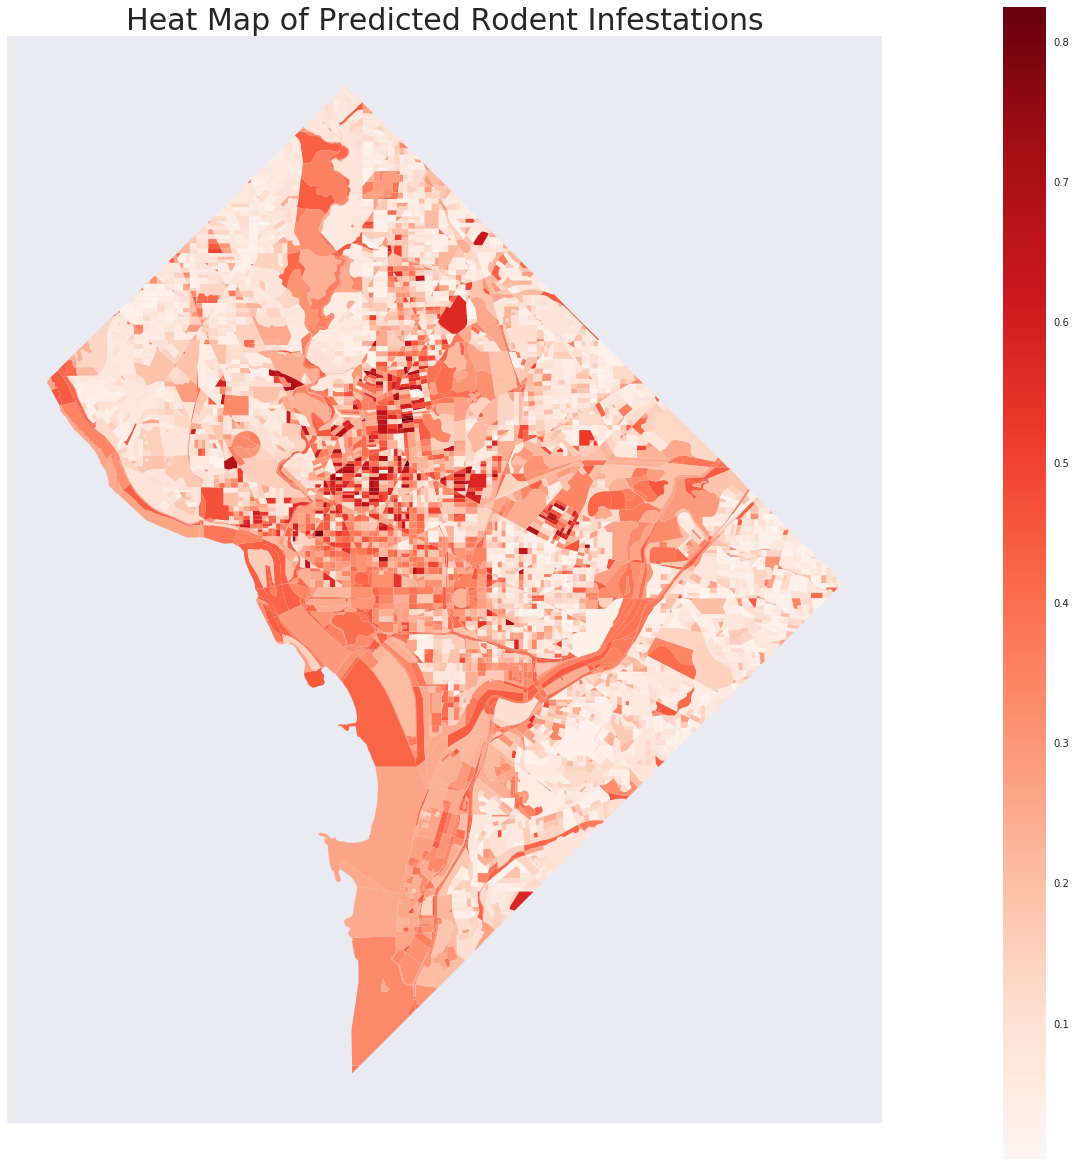

In [10]:
## Map of top N predictions
predicted.index = predicted.index.astype(str)
pred_to_blocks = blocks.merge(predicted, how='left', left_on='GEOID', right_index=True)
pred_to_blocks = pred_to_blocks.to_crs(epsg=2248)
pred_to_blocks['predicted_prob_2'] = pred_to_blocks.predicted_prob ** 2

fig, ax = plt.subplots(figsize=(20,20))
pred_to_blocks.plot('predicted_prob_2', ax=ax, cmap='Reds', alpha=1, linewidth=0, edgecolor=None)
ax.set_title('Heat Map of Predicted Rodent Infestations', fontsize=30)
ax.set_xticklabels('')
ax.set_yticklabels('')
ax.grid(False)
ax.set_aspect('equal')

cax = fig.add_axes([0.9, 0.1, 0.03, 0.8])
sm = plt.cm.ScalarMappable(cmap='Reds', norm=plt.Normalize(vmin = pred_to_blocks.predicted_prob_2.min(), vmax = pred_to_blocks.predicted_prob_2.max()))
sm._A = []
fig.colorbar(sm, cax=cax)
cax.tick_params(labelsize=10) 
plt.savefig('figures/'+filename+'_heat_map.png', bbox_inches='tight')

## Match Predictions to MAR

In [11]:
import yaml

with open('config.yml') as f:
    config = yaml.load(f)

dwp = config['dcsedwp']
dcgis = config['dcgisprd']

import cx_Oracle
dsn_tns = cx_Oracle.makedsn(dcgis['host'], dcgis['port'], service_name=dcgis['service_name'])
dcgisprd = cx_Oracle.connect(dcgis['username'], dcgis['password'], dsn_tns)

In [12]:
mar = pd.read_sql('''
select 
    address_id,
    marid,
    status,
    addrnum,
    stname,
    street_type,
    quadrant,
    fulladdress,
    city,
    state,
    census_tract,
    census_block,
    census_blockgroup,
    ward,
    anc,
    smd,
    LATITUDE,
    LONGITUDE
    
from MARDBA.VW_ADDRESS
where status='ACTIVE'
''', dcgisprd)
mar['GEOID'] = '11001'+mar['CENSUS_BLOCK'].str.replace(' ', '')
mar = mar.set_index('GEOID')
address_to_block = predicted.merge(mar, how='left', left_index=True, right_index=True)

## Randomly select address for each target

In [13]:
size = 1
replace = False
fn = lambda obj: obj.loc[np.random.choice(obj.index, size, replace)]
addresses = address_to_block.reset_index().groupby('GEOID').apply(fn)

## Select 100 targets for Field Validation

In [14]:
targets = pd.DataFrame()
for i in np.arange(.5, .9, .1):
    
#    not_recent = has_address[has_address.call_past_3m==0]
    has_address = addresses[(addresses.ADDRNUM.isnull()==False)]
    binned = has_address[(has_address.predicted_prob > i) & (has_address.predicted_prob <= (i + .1))]
    
    if binned.empty==True:
        continue
    else:
        samp = binned.sample(n=25)
        targets = pd.concat((targets, samp), axis=0)
targets[['MARID', 'FULLADDRESS', 'WARD', 'ANC', 'SMD']].sort_values('SMD').to_csv('data/Proactive_Rodent_Control_Target_List.csv', index=False)

## Validating list

In [15]:
geometry = [Point(xy) for xy in zip(targets.LONGITUDE.apply(float), targets.LATITUDE.apply(float))]
crs = {'init': 'epsg:4326'}
points = gpd.GeoDataFrame(targets, crs=crs, geometry=geometry)

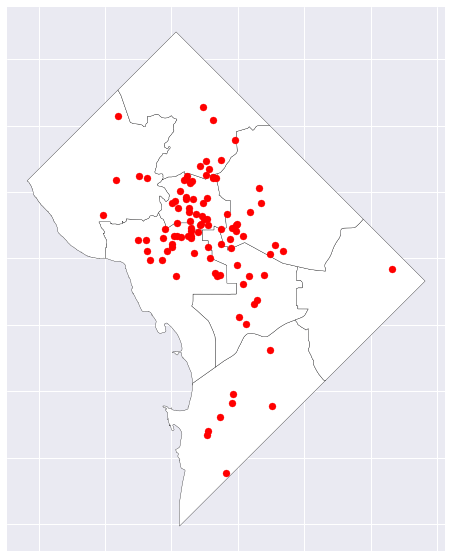

In [16]:
wards = gpd.read_file('data/Wards.geojson')

plt_wards = wards.to_crs(epsg = 2248)
plt_points = points.to_crs(epsg = 2248)

fig, ax = plt.subplots(figsize=(10,10))
plt_wards.plot(ax=ax, color='white', edgecolor = 'black')
plt_points.plot(ax=ax, color='red')
ax.set_xticklabels('')
ax.set_yticklabels('')
ax.set_aspect('equal')
plt.savefig('target_map.png', bbox_inches='tight')
plt.show()

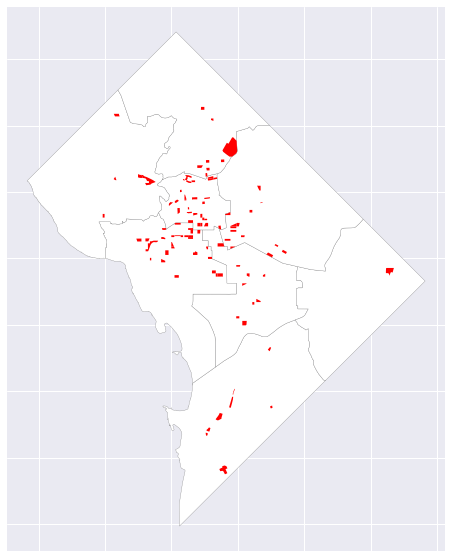

In [17]:
targets_to_blocks = gpd.sjoin(blocks, points.drop('GEOID', axis = 1), how='inner', op='intersects')

fig, ax = plt.subplots(figsize=(10,10))
wards.to_crs(epsg=2248).plot(ax=ax, color='white', edgecolor = 'grey')
targets_to_blocks.to_crs(epsg=2248).plot(ax=ax, color='red')
ax.set_xticklabels('')
ax.set_yticklabels('')
ax.set_aspect('equal')
plt.savefig('target_to_blocks.png', bbox_inches='tight')
plt.show()